<a href="https://colab.research.google.com/github/PhoenixAlpha23/ML-models/blob/main/Accredian_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded  the fraud.csv file and read its top 5 rows

In [1]:
import numpy as np
import pandas as pd

data= pd.read_csv('/content/Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


**To check the null values**

In [2]:
data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,1
nameDest,1
oldbalanceDest,1
newbalanceDest,1
isFraud,1


**Drop the null value rows**
because there is only 1 row which has null(NaN) values

In [3]:
data.dropna(inplace=True)
data.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


**Feature Engineering**

* data['amount_balance_ratio']: Calculates the ratio of the transaction amount to the original balance in the customer's account (oldbalanceOrg).Added 1 to oldbalanceOrg to avoid division by zero error.

* data['balance_change_orig']: Calculates the change in balance for the Customer's account.

* data['balance_change_dest']: Calculates the change in balance for the destination account.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Label encoding for categorical variables
le = LabelEncoder()
data['type_encoded'] = le.fit_transform(data['type'])

# Feature engineering
data['amount_balance_ratio'] = data['amount'] / (data['oldbalanceOrg'] + 1)
data['balance_change_orig'] = data['newbalanceOrig'] - data['oldbalanceOrg']
data['balance_change_dest'] = data['newbalanceDest'] - data['oldbalanceDest']

Selected features for model, and seperated the isFraud column as y- to be predicted.

In [5]:
features = ['step', 'type_encoded', 'amount', 'amount_balance_ratio',
        'oldbalanceOrg', 'newbalanceOrig',
        'balance_change_orig', 'balance_change_dest'
    ]
X = data[features]
y = data['isFraud']

 ***used stratify argument to maintain 'isfraud' ratio in both training and testing splits***

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import time

# Initializing the RandomForestClassifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight={0: 1, 1: 5},
    random_state=42,
    warm_start=True,
    oob_score=True # Enabled out-of-bag error to monitor performance
)

#Early stopping criteria
min_oob_error = float('inf')
n_estimators_to_add = 10
max_no_improvement = 10
no_improvement_count = 0
total_estimators = 0

start_time = time.time()
# Training the model
for _ in range(5):  # Maximum 5 iterations
    rf_model.n_estimators += n_estimators_to_add  # Add more estimators
    rf_model.fit(X_train, y_train)
    total_estimators = rf_model.n_estimators

    oob_error = 1 - rf_model.oob_score_

    if oob_error < min_oob_error:
        min_oob_error = oob_error
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= max_no_improvement:
        print(f"Early stopping triggered after {total_estimators} total estimators.")
        break

end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")


# Predictions and evaluation (using the best model)
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

Training time: 44.72 seconds


In [8]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     49358
         1.0       0.97      0.91      0.94        32

    accuracy                           1.00     49390
   macro avg       0.98      0.95      0.97     49390
weighted avg       1.00      1.00      1.00     49390


ROC AUC Score:
0.9685347360103732


## Accuracy and precison metric separately

In [13]:
from sklearn.metrics import accuracy_score, precision_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")

Accuracy: 0.9999
Precision: 0.9667


## Visualizations

**Confusion Matrix**

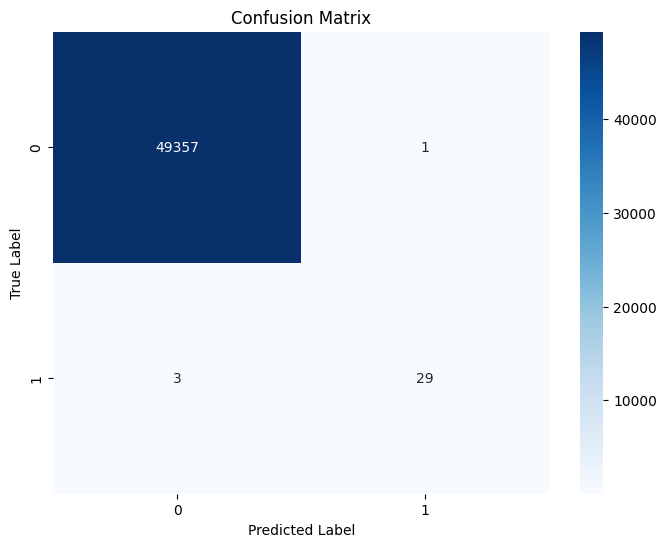

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

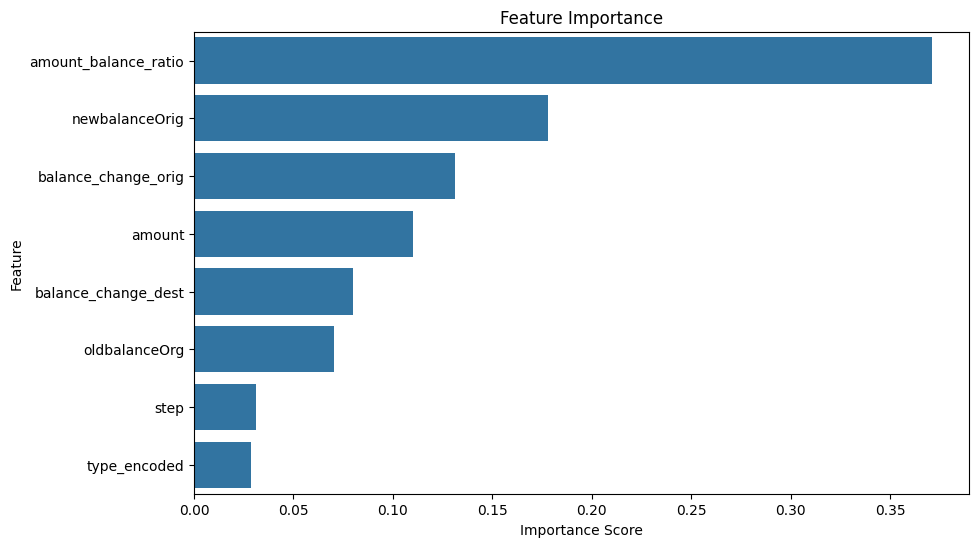

In [10]:
feature_importances = rf_model.feature_importances_

#DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Plotting with pyplot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

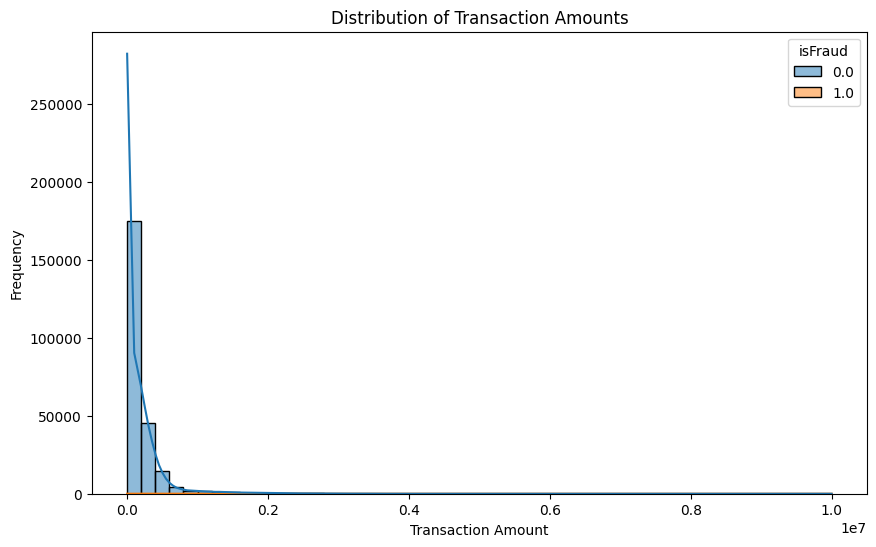

In [11]:
viz_df = data[['amount', 'isFraud']].copy()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=viz_df, x='amount', hue='isFraud', bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()